# NWA suntans: energy low vs high, maps



In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt

import pynsitu as pin
crs = pin.maps.crs

import nwatools as nwa

ERROR 1: PROJ: proj_create_from_database: Open of /home1/datahome/aponte/.miniconda3/envs/equinox/share/proj failed


In [2]:
if False:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    #cluster = PBSCluster(cores=28, processes=14)
    #cluster = PBSCluster(cores=14, processes=7)
    w = cluster.scale(jobs=2, walltime='03:00:00')
    #
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

---
## load data

In [3]:
store = True

In [4]:
_, grd = nwa.load_surf()
#grd["cells"] = grd["cells"].where( grd.cells!=999999, other=-999999 )

zarr = os.path.join(nwa.suntans_dir, "suntans_2km_surf_mean")
dsm = xr.open_zarr(zarr)

zarr = os.path.join(nwa.suntans_dir, f"suntans_2km_surf_low_mean")
dslm = xr.open_zarr(zarr)

In [5]:
ds = dsm[["mke", "ke", "eta2", "temp2"]]

# need to compute variance contribution from mean fields
ds["meta2"] = dsm["eta"]**2
ds["mtemp2"] = dsm["temp"]**2

ds["lke"] = dslm["ke"] - ds["mke"]
ds["hke"] = ds["ke"] - dslm["ke"]

ds["leta2"] = dslm["eta2"] - ds["meta2"]
ds["heta2"] = ds["eta2"] - dslm["eta2"]

ds["ltemp2"] = dslm["temp2"] - ds["temp2"]
ds["htemp2"] = ds["temp2"] - dslm["temp2"]

ds = ds.rename(mke="ke_mean", lke="ke_low", hke="ke_high", ke="ke_total",
               meta2="eta_mean", leta2="eta_low", heta2="eta_high", eta2="eta_total",
               mtemp2="temp_mean", ltemp2="temp_low", htemp2="temp_high", temp2="temp_total",
              )

ds = ds.assign_coords(**grd)
ds["cells"] = ds.cells.where( ds.cells!=999999, other=-999999 )

In [6]:
# add ratios
for v in ["ke", "eta", "temp"]:
    total = ds[v+"_total"].where( ds[v+"_total"]>0, other=1.)
    r = (ds[v+"_mean"]+ds[v+"_low"]) / total
    r = r.where(r<=1, other=1.)
    ds[v+"_r"] = r

---
## histograms

In [7]:
# max is 1e-16
#error = np.abs(ds["ke_total"] - ds["ke_mean"] - ds["ke_low"] - ds["ke_high"])
#error.plot.hist(bins=bins, color="k")

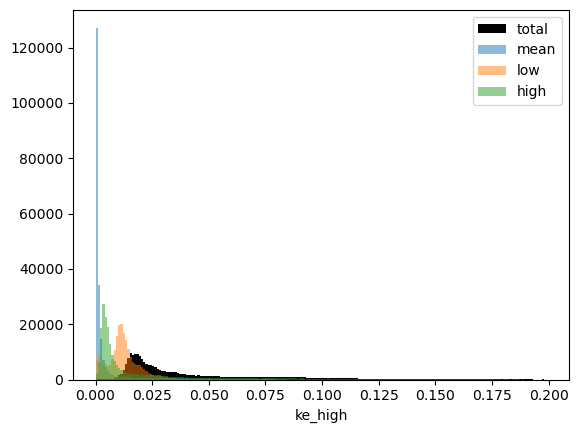

In [8]:
bins = np.arange(0, .2, .001)

fig, ax = plt.subplots(1,1)

ds["ke_total"].plot.hist(ax=ax, bins=bins, color="k", label="total")
ds["ke_mean"].plot.hist(ax=ax, bins=bins, alpha=.5, label="mean")
ds["ke_low"].plot.hist(ax=ax, bins=bins, alpha=.5, label="low")
ds["ke_high"].plot.hist(ax=ax, bins=bins, alpha=.5, label="high")

ax.legend()
#ax.set_yscale("log")

Text(0.5, 1.0, 'energy fraction: low + mean / total')

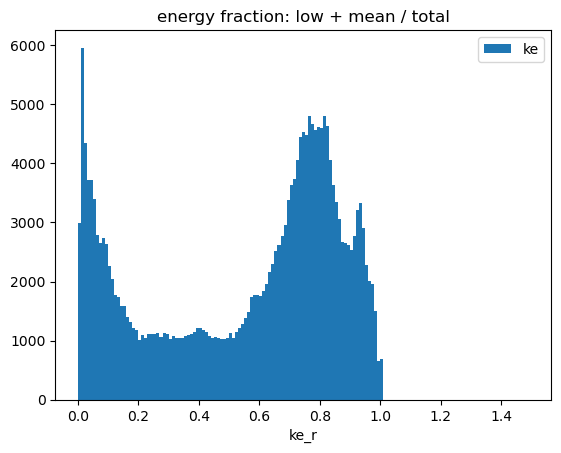

In [9]:
bins = np.arange(0, 1.5, .01)

fig, ax = plt.subplots(1,1)

ds["ke_r"].plot.hist(ax=ax, bins=bins, label="ke")
#ds["eta_r"].plot.hist(ax=ax, bins=bins, label="eta", alpha=.5)

ax.legend()
#ax.set_yscale("log")
#ax.set_ylim(1e3,None)
ax.set_title("energy fraction: low + mean / total")

In [36]:
def plot_map(zoom, da, title, levels, cmap, levels_ctr=None, bathy_kw=None):

        
    fig, ax = nwa.map_init(zoom, bathy=(grd, ds), bathy_kw=bathy_kw)
    #,bathy_kw = dict(colors="w"))

    _, _, tri, cbar = grd.suntans.contourf(da, clevs=levels, cmap=cmap, transform=crs, extend="both")
    if levels_ctr is not None:
        _, _, tri, cbar = grd.suntans.contourf(da, clevs=levels_ctr, 
                                               colors="0.5", linewidths=2, filled=False, 
                                               transform=crs,
                                              )
    #_, _, poly, cbar = grd.suntans.plotcelldata(da, vmax=1., cmap='inferno', transform=crs)

    nwa.plot_moorings(ax, zorder=30, s=100)
    
    #hdl = ax.scatter(ds.xv, ds.yv, s=1, c=da, transform=crs, vmax=1., cmap="inferno")
    #fig.colorbar(hdl)
    
    ax.set_title(title)

In [38]:
levels_ratio = np.arange(0, 1.01,.05)

def plot_ke_maps(zoom):

    plot_map(zoom,
             ds["ke_r"], "ke fraction: mean + low / total",
             levels_ratio, "Spectral_r",
             levels_ctr=[0.5])


    lvls = np.arange(0, .101, .002)

    plot_map(zoom,
             ds["ke_total"], "ke: total", 
             lvls, "inferno",
             bathy_kw = dict(colors="0.7"),
            )

    plot_map(zoom,
             ds["ke_mean"] + ds["ke_low"], "ke: mean + low", 
             lvls, "inferno",
             bathy_kw = dict(colors="0.7"),         
            )

    plot_map(zoom,
             ds["ke_high"], "ke: high", 
             lvls, "inferno",
             bathy_kw = dict(colors="0.7"),         
            )
    

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting

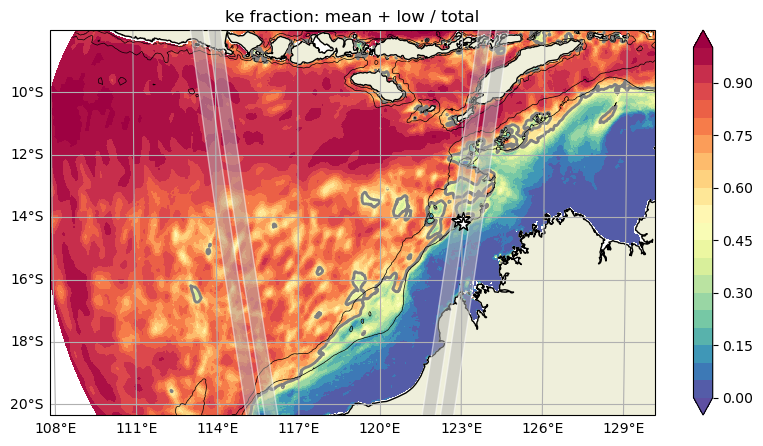

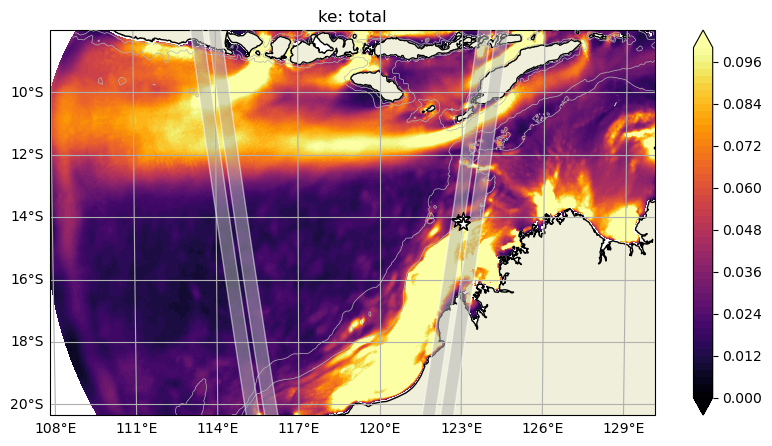

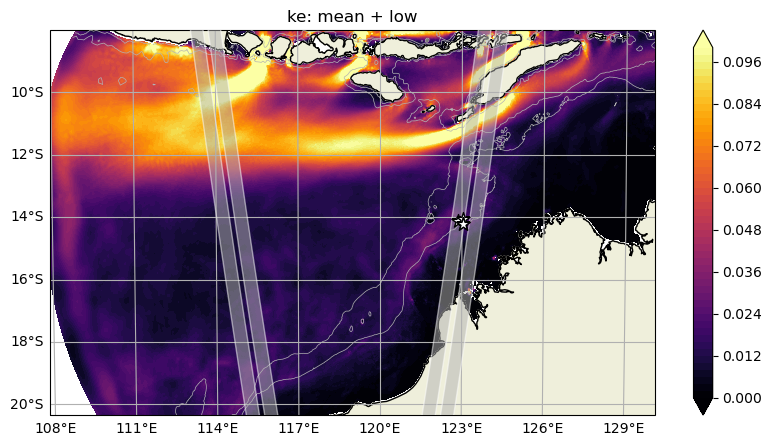

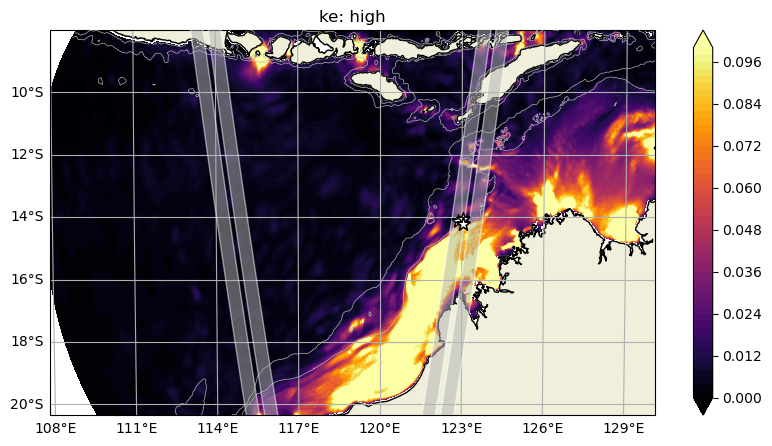

In [39]:
plot_ke_maps("large")

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting

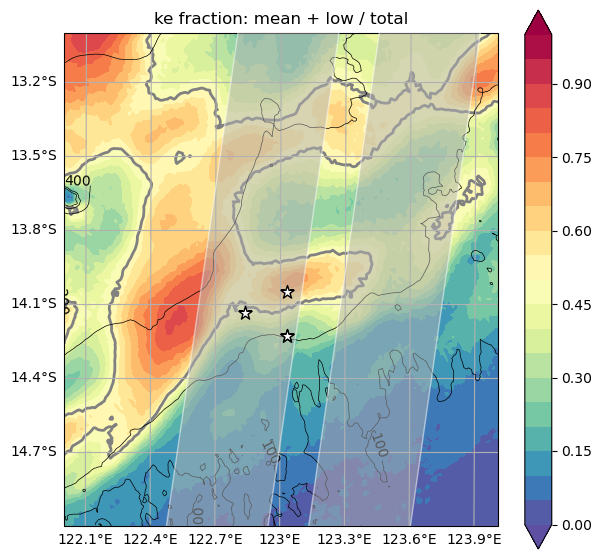

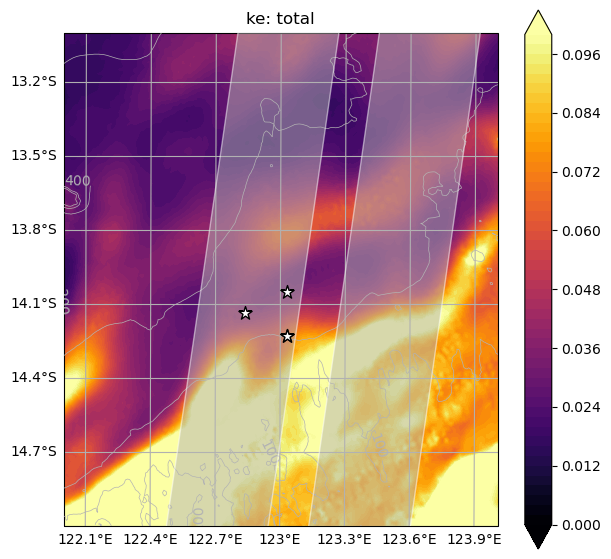

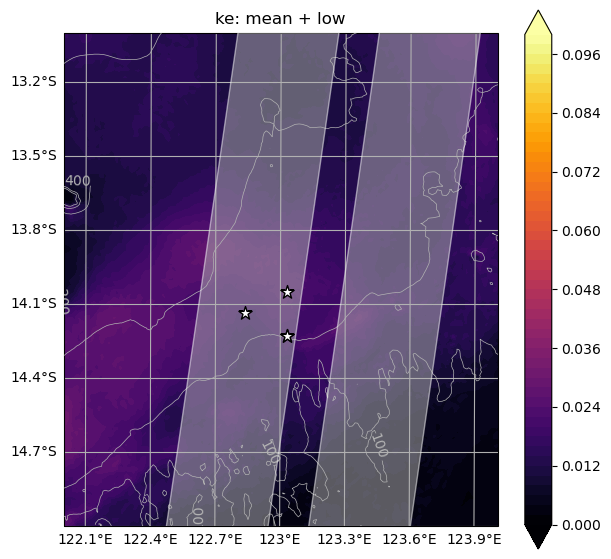

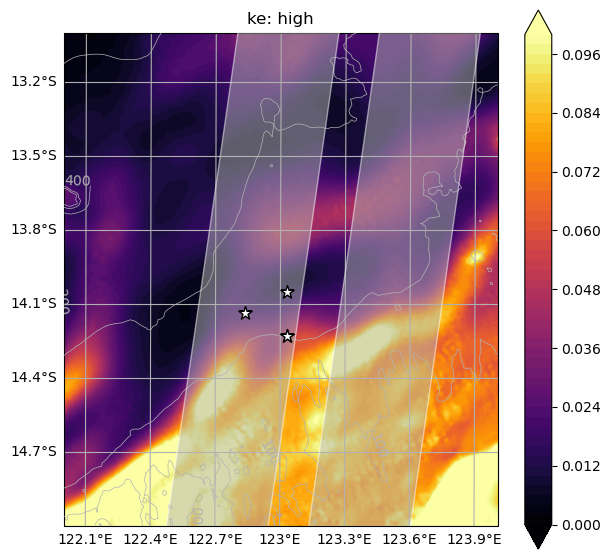

In [ ]:
plot_ke_maps("cp")

## mean currents ...

---

In [ ]:
cluster.close()